In [15]:
%load_ext autoreload
%autoreload 2
# Python base libraries
import random
# Main libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm import tqdm_notebook
# Deep Learning libraries
import keras
import keras.backend as K
from keras.models import load_model
# Local libraries
from models.densenet import DenseNetFCN
from utils.dataset import *
from utils.gpu import reserve_gpus

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
GPU = 2
ids = reserve_gpus(GPU)
print(f"{len(ids)} GPUs allocated!")
print(f"Allocating GPUs: {','.join(map(str, ids))}")

2 GPUs allocated!
Allocating GPUs: 0,1


In [4]:
# SETTING VARIABLES
dataset_path = "../tfm_keras/dataset"
dataset_path_test = "../tfm_keras/dataset_test"
dataset_path_val = "../tfm_keras/dataset_val"

# Types of images to use
image_types = ["RAW", "FORCE"] # Not using FRET images
# Crops of size crop_size x crop_size will be made
crop_size = 1024
# Tukey window mask will be applied to the force to reduce high intensity border artefacts
tukey_p = 0.1 # 10%

In [5]:
print('Loading validation cell...')
X_val, y_val = import_cells(dataset_path_val, image_types=image_types, tukey_p=tukey_p)
print(f"{len(y_val)} cells loaded!")
print()

for i in tqdm_notebook(range(len(X_val))):
    X_val[i] = crop_to_size(X_val[i], crop_size)
    X_val[i] = np.log(X_val[i], where=X_val[i]>=1., out=np.zeros_like(X_val[i]))
    y_val[i] = crop_to_size(y_val[i], crop_size)
    y_val[i] = np.log(y_val[i], where=y_val[i]>=1., out=np.zeros_like(y_val[i]))
X_val = np.array(X_val)
y_val = np.array(y_val)

Loading validation cell...
* 20160810-002-xy6
181 cells loaded!



In [6]:
%%time
model_ = load_model('results/result_densenet.h5')

if GPU == 1:
    model = model_
else:
    model = keras.utils.multi_gpu_model(
        model_,
        gpus=GPU,
        cpu_merge=True,
        cpu_relocation=False
    )

Instructions for updating:
Colocations handled automatically by placer.


/home/nicolas/.local/share/virtualenvs/InSilicoTFM-OcUJXhN-/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


CPU times: user 15.3 s, sys: 797 ms, total: 16.1 s
Wall time: 16.1 s


CPU times: user 737 ms, sys: 298 ms, total: 1.04 s
Wall time: 1.11 s


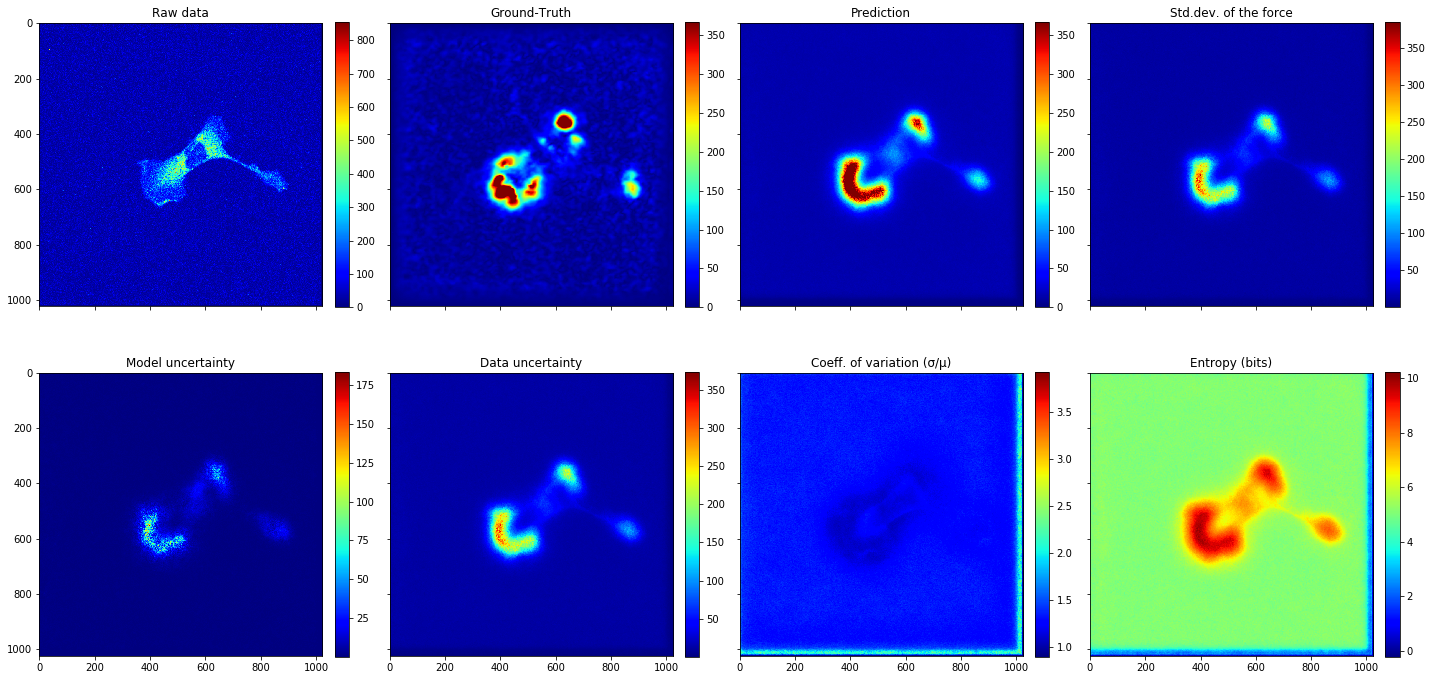

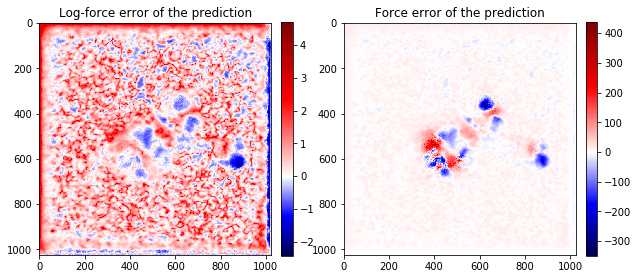

In [18]:
i = 0
N = 4
current_image = X_val[i]
current_force = y_val[i]
batch_X = np.repeat(
    np.expand_dims(X_val[i], axis=0),
    repeats=N,
    axis=0
)
batch_y = y_val[i:i+1]
%time y_pred = model.predict(batch_X)

i = 0
visualize_cell(current_image, current_force, y_pred, figsize=(20, 10))
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

error = (y_pred[i, :, :, 0:1] + 0.5*y_pred[i, :, :, 1:2] - batch_y[i]).squeeze(-1)
ax[0].set_title('Log-force error of the prediction')
divnorm = mpl.colors.DivergingNorm(vmin=error.min(), vcenter=0, vmax=error.max())
im = ax[0].imshow(error, norm=divnorm, cmap='seismic')
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

error = (np.exp(y_pred[i, :, :, 0:1] + 0.5*y_pred[i, :, :, 1:2]) - np.exp(batch_y[i])).squeeze(-1)
ax[1].set_title('Force error of the prediction')
divnorm = mpl.colors.DivergingNorm(vmin=error.min(), vcenter=0, vmax=error.max())
im = ax[1].imshow(error, norm=divnorm, cmap='seismic')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

plt.show()

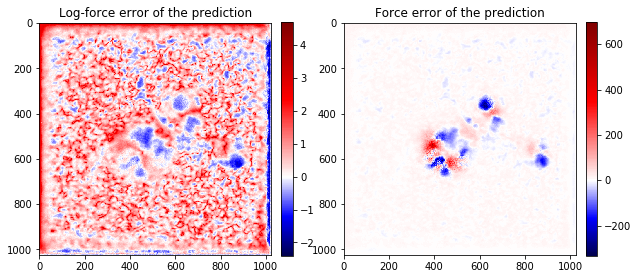

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

error = (y_pred[i, :, :, 0:1] + 0.5*y_pred[i, :, :, 1:2] - batch_y[i]).squeeze(-1)
ax[0].set_title('Log-force error of the prediction')
divnorm = mpl.colors.DivergingNorm(vmin=error.min(), vcenter=0, vmax=error.max())
im = ax[0].imshow(error, norm=divnorm, cmap='seismic')
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

error = (np.exp(y_pred[i, :, :, 0:1] + 0.5*y_pred[i, :, :, 1:2]) - np.exp(batch_y[i])).squeeze(-1)
ax[1].set_title('Force error of the prediction')
divnorm = mpl.colors.DivergingNorm(vmin=error.min(), vcenter=0, vmax=error.max())
im = ax[1].imshow(error, norm=divnorm, cmap='seismic')
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

plt.show()

In [19]:
from PIL import Image, ImageDraw, ImageFont
hd_size = 1024
font_size = 30
font = ImageFont.truetype('utils/roboto.ttf', font_size)

true_text = 'Traction Force ground truth'
true_color = (0, 255, 255)
true_size = font.getsize(true_text)
pred_text = 'Traction Force prediction'
pred_color = (255, 0, 255)
pred_size = font.getsize(pred_text)
label_text = '20160810-002-xy6'
label_color = (255, 255, 255)
label_size = font.getsize(label_text)

legend_height = true_size[1] + label_size[1]

side_margin = 10
image = Image.new('RGB', (hd_size, legend_height))
d = ImageDraw.Draw(image)
d.text((side_margin, 0), true_text, font=font, fill=true_color)
d.text((hd_size-side_margin-pred_size[0], 0), pred_text, font=font, fill=pred_color)
d.text((side_margin, true_size[1]), label_text, font=font, fill=label_color)
text = np.array(image)

In [21]:
#%%time
T = len(X_val)
video_X = np.empty((T, crop_size, crop_size))
video_y = np.empty((T, crop_size, crop_size))
video_y_pred_mu = np.empty((T, crop_size, crop_size))
video_y_pred_sig2 = np.empty((T, crop_size, crop_size))
video_y_pred_mean = np.empty((T, crop_size, crop_size))
video_y_pred_std = np.empty((T, crop_size, crop_size))
video_y_pred_std_alea = np.empty((T, crop_size, crop_size))
video_y_pred_std_epis = np.empty((T, crop_size, crop_size))
video_y_pred_cv = np.empty((T, crop_size, crop_size))
video_y_pred_entropy = np.empty((T, crop_size, crop_size))
# MC instances
N = 4

for i in tqdm_notebook(range(T), desc='Generation of the video'):
    current_image = X_val[i][..., 0]
    current_force = np.exp(y_val[i][..., 0])
    batch_X = np.repeat(
        np.expand_dims(X_val[i], axis=0),
        repeats=N,
        axis=0
    )
    y_pred = model.predict(batch_X)

    mu = y_pred[..., 0]
    sig2 = y_pred[..., 1]**2
    logsig2 = 0.5*np.log(y_pred[..., 1])

    video_y_pred_mu[i] = mu.mean(axis=0)
    video_y_pred_sig2[i] = np.exp(logsig2).mean(axis=0)

    mean = np.exp(mu + 0.5*sig2)
    var = np.exp(2*mu + sig2) * (np.exp(sig2) - 1)

    y_pred_mean = mean.mean(axis=0)
    y_pred_epis = mean.var(axis=0)
    y_pred_alea = var.mean(axis=0)
    y_pred_std = np.sqrt(y_pred_epis + y_pred_alea)
    y_pred_cv = np.sqrt(np.exp(sig2+0.5)-1).mean(axis=0)
    y_pred_entropy = np.log2(np.exp(0.5*logsig2 + mu + 0.5) * np.sqrt(2 * np.pi)).mean(axis=0)

    frame = np.stack([
        y_pred_mean,
        current_force,
        np.maximum(y_pred_mean, current_force),
    ], axis=-1)

    video_X[i] = current_image
    video_y[i] = current_force
    video_y_pred_mean[i] = y_pred_mean
    video_y_pred_std[i] = y_pred_std
    video_y_pred_std_alea[i] = np.sqrt(y_pred_alea)
    video_y_pred_std_epis[i] = np.sqrt(y_pred_epis)
    video_y_pred_cv[i] = y_pred_cv
    video_y_pred_entropy[i] = y_pred_entropy

Missing information: 656kb


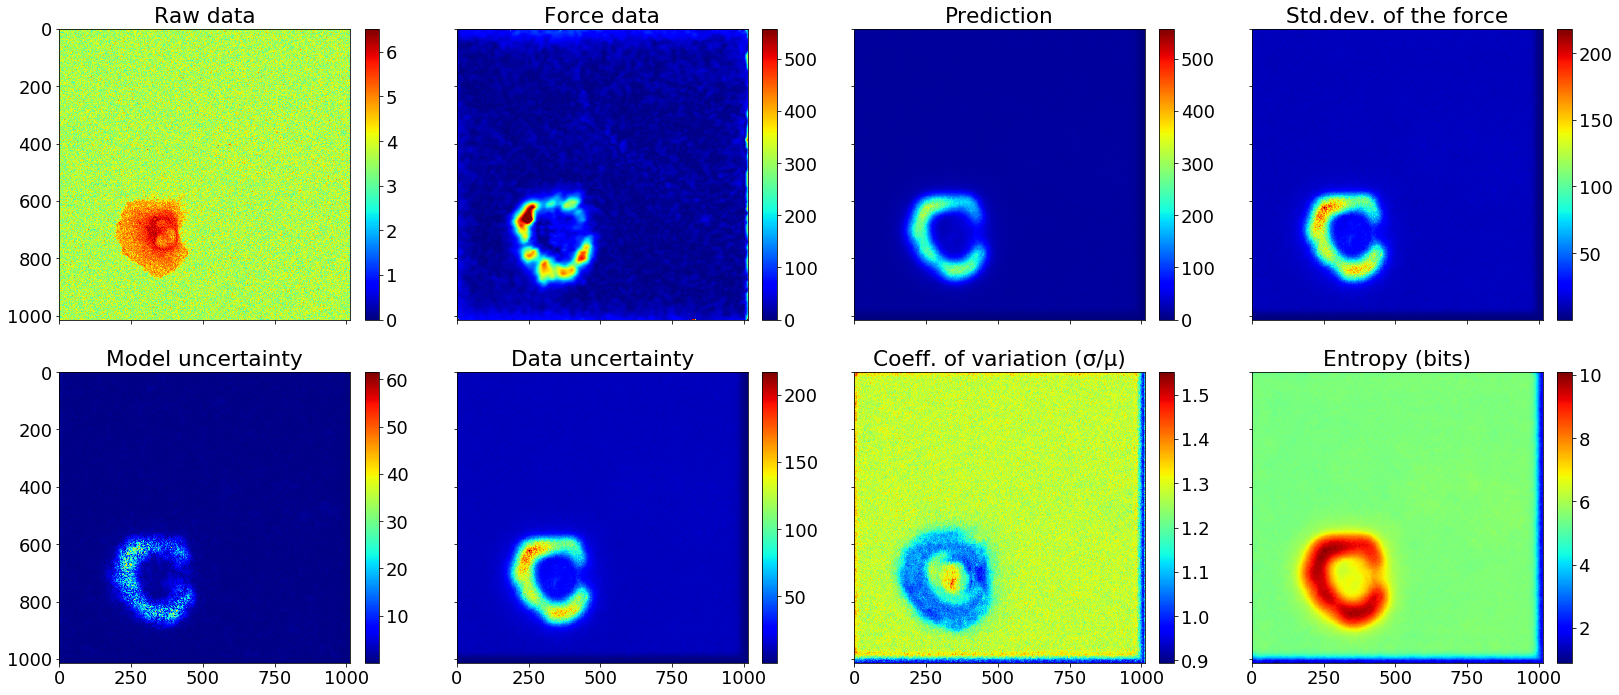

In [59]:
import matplotlib
matplotlib.rc("font", size=18)
i = 144
b = 5
f, ax = plt.subplots(2, 4, figsize=(23, 10), sharex='col', sharey='row')
ax = ax.ravel()

cmap = "jet"

ax[0].set_title('Raw data')
im = ax[0].imshow(video_X[i, b:-b, b:-b], vmin=0, cmap=cmap)
plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

max_intensity = max(np.percentile(video_y[i, b:-b, b:-b], 99.9), np.percentile(video_y_pred_mean[i, b:-b, b:-b], 99.9))

ax[1].set_title('Force data')
im = ax[1].imshow(video_y[i, b:-b, b:-b], vmin=0, vmax=max_intensity, cmap=cmap)
plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

ax[2].set_title('Prediction')
im = ax[2].imshow(video_y_pred_mean[i, b:-b, b:-b], vmin=0, vmax=max_intensity, cmap=cmap)
plt.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)

ax[3].set_title('Std.dev. of the force')
im = ax[3].imshow(video_y_pred_std[i, b:-b, b:-b], cmap=cmap)
plt.colorbar(im, ax=ax[3], fraction=0.046, pad=0.04)

ax[4].set_title('Model uncertainty')
im = ax[4].imshow(video_y_pred_std_epis[i, b:-b, b:-b], cmap=cmap)
plt.colorbar(im, ax=ax[4], fraction=0.046, pad=0.04)

ax[5].set_title('Data uncertainty')
im = ax[5].imshow(video_y_pred_std_alea[i, b:-b, b:-b], cmap=cmap)
plt.colorbar(im, ax=ax[5], fraction=0.046, pad=0.04)

ax[6].set_title('Coeff. of variation (σ/μ)')
im = ax[6].imshow(video_y_pred_cv[i, b:-b, b:-b], cmap=cmap)
plt.colorbar(im, ax=ax[6], fraction=0.046, pad=0.04)

ax[7].set_title('Entropy (bits)')
im = ax[7].imshow(video_y_pred_entropy[i, b:-b, b:-b], cmap=cmap)
plt.colorbar(im, ax=ax[7], fraction=0.046, pad=0.04)

plt.subplots_adjust(wspace=0.1)

plt.tight_layout()
plt.savefig("results/prediction.pdf")

entropy_pred = video_y_pred_entropy[i, b:-b, b:-b].sum(dtype=int)
print(f"Missing information: {entropy_pred // 8000}kb")

In [60]:
video = []

for i in tqdm_notebook(range(T), desc='Generation of the video'):
    frame = np.stack([
        video_y_pred_mean[i],
        video_y[i],
        np.maximum(video_y_pred_mean[i], video_y[i]),
    ], axis=-1)
    video.append(frame)

video = np.array(video)
video = np.clip(255 * video / np.percentile(video, 99.9), 0, 255).astype(np.uint8)
print('Shape of video tensor:', video.shape)

# Add Legend
for i in range(len(X_hd)):
    video[i, :legend_height] = text


Shape of video tensor: (181, 1024, 1024, 3)


In [62]:
from IPython.display import HTML
import imageio, time

fps=10
video_path = 'results/force_prediction.mp4'
imageio.mimwrite(video_path, video, fps=fps)

In [63]:
HTML(f'<video width="512" height="512" controls loop><source src="./{video_path}?{time.time()}"></video>')

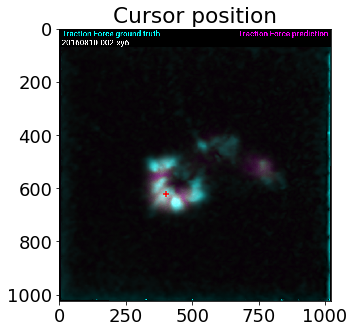

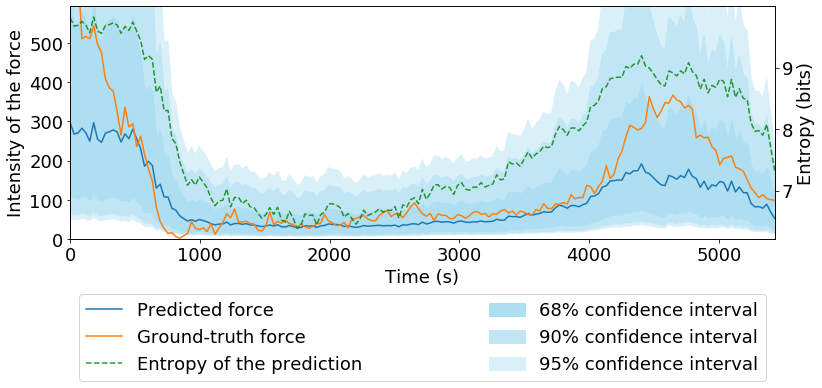

In [64]:
import scipy.stats as st
#py, px = 700, 300
#py, px = 700, 230
py, px = 620, 400
plt.figure(figsize=(5, 5))
plt.title('Cursor position')
plt.imshow(video[10])
plt.scatter(px, py, c='r', marker='+')
plt.show()

pred = video_y_pred_mean[:, py, px]
mean, std = video_y_pred_mu[:, py, px], np.sqrt(video_y_pred_sig2[:, py, px])
l1error = st.lognorm.ppf(0.160, std, mean, np.exp(mean))
h1error = st.lognorm.ppf(0.840, std, mean, np.exp(mean))
l2error = st.lognorm.ppf(0.050, std, mean, np.exp(mean))
h2error = st.lognorm.ppf(0.950, std, mean, np.exp(mean))
l3error = st.lognorm.ppf(0.025, std, mean, np.exp(mean))
h3error = st.lognorm.ppf(0.975, std, mean, np.exp(mean))
ground_truth = video_y[:, py, px]

t = np.linspace(0, 30*len(pred), len(pred))
plt.figure(figsize=(12, 6))

ax1 = plt.gca()
ax1.fill_between(t, l1error, h1error, color='#AEDEF1', label="68% confidence interval", zorder=1.2)
ax1.fill_between(t, l2error, h2error, color='#C0E5F4', label="90% confidence interval", zorder=1.1)
ax1.fill_between(t, l3error, h3error, color='#DAF0f8', label="95% confidence interval", zorder=1.0)
ax1.plot(t, pred, label='Predicted force')
ax1.plot(t, ground_truth, label='Ground-truth force')
ax1.set_xlim(0, 30*len(pred))
ax1.set_ylim(0, 2*np.max(pred))
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Intensity of the force')

#'''
ax1.plot(0, 0, 'green', linestyle="dashed", alpha=0.8, label='Entropy of the prediction')
ax2 = ax1.twinx()
ax2.plot(t, video_y_pred_entropy[:, py, px], 'green', linestyle="dashed", alpha=0.8, label='Entropy of the prediction')
ax2.set_ylabel("Entropy (bits)")
#ax2.legend()
#'''

def flip(items, ncol):
    idx = np.arange(len(items)).reshape(2, -1).reshape(-1, order="F")
    return np.array(items)[idx], np.array(ncol)[idx]

handles, labels = ax1.get_legend_handles_labels()
order = [0, 5, ]
ax1.legend(mode="expand",
           loc='upper center', bbox_to_anchor=(0., -.5, 1., .3), fancybox=True, ncol=2)
plt.tight_layout()
plt.savefig("results/pixel_prediction.pdf")

In [65]:
print("68% C.I:", np.mean((h1error > ground_truth) & (ground_truth > l1error)))
print("90% C.I:", np.mean((h2error > ground_truth) & (ground_truth > l2error)))     
print("95% C.I:", np.mean((h3error > ground_truth) & (ground_truth > l3error)))      

68% C.I: 0.8453038674033149
90% C.I: 0.9723756906077348
95% C.I: 0.9779005524861878


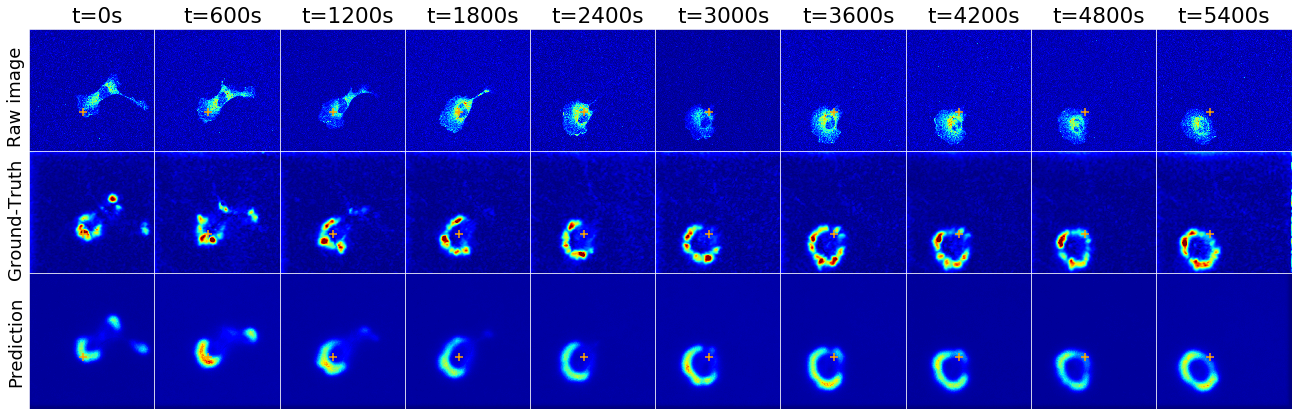

In [66]:
N = 10
b = 5
cmap = "jet"
with plt.rc_context({'axes.edgecolor':'white'}):
    fig, ax = plt.subplots(3, N, figsize=(23, 7), gridspec_kw = {'wspace':-0.2, 'hspace':-0.1})
    for i in range(N):
        f = int((T-1) / (N-1) * i) # Frame number
        ax[0, i].set_title(f"t={30*f}s")
        ax[0, i].imshow(np.exp(video_X[f, b:-b, b:-b]), cmap=cmap)
        ax[0, i].scatter(px, py, c='orange', marker='+', s=80)
        ax[0, i].set_xticks([])
        ax[0, i].set_yticks([])

        vmax = max_intensity = max(
            np.percentile(video_y[f, b:-b, b:-b], 99.9),
            np.percentile(video_y_pred_mean[f, b:-b, b:-b], 99.9)
        )
        ax[1, i].imshow(video_y[f, b:-b, b:-b], vmin=0, vmax=vmax, cmap=cmap)
        ax[1, i].scatter(px, py, c='orange', marker='+', s=80)
        ax[1, i].set_xticks([])
        ax[1, i].set_yticks([])

        ax[2, i].imshow(video_y_pred_mean[f, b:-b, b:-b], vmin=0, vmax=vmax, cmap=cmap)
        ax[2, i].scatter(px, py, c='orange', marker='+', s=80)
        ax[2, i].set_xticks([])
        ax[2, i].set_yticks([])

    ax[0, 0].set_ylabel("Raw image")
    ax[1, 0].set_ylabel("Ground-Truth")
    ax[2, 0].set_ylabel("Prediction")
    
    plt.savefig("results/frame.pdf", bbox_inches = 'tight')

In [ ]:
import matplotlib
matplotlib.rc("font", size=18)

b = 20
vmins = [
    video_y_pred_cv[:, b:-b, b:-b].min(),
    video_y_pred_entropy[:, b:-b, b:-b].min(),
]
vmaxs = [
    np.exp(np.percentile(video_X[:, b:-b, b:-b], 99.9)),
    np.percentile(video_y[:, b:-b, b:-b], 99.9),
    video_y_pred_std[:, b:-b, b:-b].max(),
    video_y_pred_std_epis[:, b:-b, b:-b].max(),
    video_y_pred_std_alea[:, b:-b, b:-b].max(),
    video_y_pred_cv[:, b:-b, b:-b].max(),
    video_y_pred_entropy[:, b:-b, b:-b].max(),
]
b = 5
for i in tqdm_notebook(range(len(video_y))):
    f, ax = plt.subplots(2, 4, figsize=(23, 10), sharex='col', sharey='row')
    ax = ax.ravel()

    cmap = "jet"

    ax[0].set_title('Raw data')
    im = ax[0].imshow(np.exp(video_X[i, b:-b, b:-b]), vmin=0, vmax=vmaxs[0], cmap=cmap)
    plt.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

    ax[1].set_title('Force data')
    im = ax[1].imshow(video_y[i, b:-b, b:-b], vmin=0, vmax=vmaxs[1], cmap=cmap)
    plt.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)

    ax[2].set_title('Prediction')
    im = ax[2].imshow(video_y_pred_mean[i, b:-b, b:-b], vmin=0, vmax=vmaxs[1], cmap=cmap)
    plt.colorbar(im, ax=ax[2], fraction=0.046, pad=0.04)

    ax[3].set_title('Std.dev. of the force')
    im = ax[3].imshow(video_y_pred_std[i, b:-b, b:-b], vmin=0, vmax=vmaxs[2], cmap=cmap)
    plt.colorbar(im, ax=ax[3], fraction=0.046, pad=0.04)

    ax[4].set_title('Model uncertainty')
    im = ax[4].imshow(video_y_pred_std_epis[i, b:-b, b:-b], vmin=0, vmax=vmaxs[3], cmap=cmap)
    plt.colorbar(im, ax=ax[4], fraction=0.046, pad=0.04)

    ax[5].set_title('Data uncertainty')
    im = ax[5].imshow(video_y_pred_std_alea[i, b:-b, b:-b], vmin=0, vmax=vmaxs[4], cmap=cmap)
    plt.colorbar(im, ax=ax[5], fraction=0.046, pad=0.04)

    ax[6].set_title('Coeff. of variation (σ/μ)')
    im = ax[6].imshow(video_y_pred_cv[i, b:-b, b:-b], vmin=vmins[0], vmax=vmaxs[5], cmap=cmap)
    plt.colorbar(im, ax=ax[6], fraction=0.046, pad=0.04)

    ax[7].set_title('Entropy (bits)')
    im = ax[7].imshow(video_y_pred_entropy[i, b:-b, b:-b], vmin=vmins[1], vmax=vmaxs[6], cmap=cmap)
    plt.colorbar(im, ax=ax[7], fraction=0.046, pad=0.04)

    plt.subplots_adjust(wspace=0.1)

    plt.tight_layout()
    plt.savefig(f"results/frames/frame_{i:03d}.png")
    plt.close()